## Resampling (Zmiana częstotliwości próbkowania)

Jednym z kluczowych wyzwań w porównywaniu sygnałów z różnych urządzeń jest różnica w ich rozdzielczości czasowej. W analizowanym przypadku:

- **Aparatura medyczna** rejestruje sygnał z częstotliwością **500 Hz** (500 próbek na sekundę).
- **Smartwatch Garmin** rejestruje sygnał z częstotliwością **128 Hz** (128 próbek na sekundę).

Aby umożliwić bezpośrednie nałożenie na siebie sygnałów konieczne było sprowadzenie ich do wspólnej częstotliwości próbkowania. Proces ten nazywamy **resamplingiem**. Może on przybierać dwie formy:

### Rodzaje resamplingu

1.  **Downsampling (Decymacja)**
    Polega na zmniejszeniu częstotliwości próbkowania. W najprostszej formie oznacza to zachowanie co $n$-tej próbki i odrzucenie pozostałych. Proces ten wiąże się z ryzykiem wystąpienia zjawiska **aliasingu** (nakładania się widm).  Dlatego przed redukcją próbek konieczne jest zastosowanie filtra dolnoprzepustowego (antyaliasingowego), aby usunąć częstotliwości wyższe niż połowa nowej częstotliwości próbkowania (zgodnie z twierdzeniem Nyquista). 

2.  **Upsampling (Interpolacja)**
    Polega na zwiększeniu częstotliwości próbkowania. Proces ten polega na wstawieniu dodatkowych próbek pomiędzy te już istniejące (np. zer), a następnie zastosowaniu filtra interpolacyjnego, który "wygładza" sygnał, uzupełniając brakujące wartości na podstawie sąsiednich punktów. Upsampling nie dodaje nowych informacji do sygnału, ale zwiększa jego rozdzielczość czasową. 

### Implementacja w projekcie

W celu ujednolicenia danych zdecydowano się na **downsampling** sygnału medycznego do częstotliwości zegarka (128 Hz). 

- Pozwala na zmianę częstotliwości o dowolny ułamek wymierny (stosunek 128/500 nie jest liczbą całkowitą), wykonując upsampling i downsampling w jednym kroku.
- Automatycznie aplikuje filtr antyaliasingowy, zapobiegając zniekształceniom sygnału podczas redukcji liczby próbek.


In [25]:
import os
import pandas as pd
from pathlib import Path

# Automatycznie znajduje plik bez względu na katalog roboczy
current_dir = Path.cwd()
project_root = current_dir if current_dir.name == "Projekt-EKG" else current_dir / "Projekt-EKG"

plik = project_root / "data" / "N38" / "N38_2025-2025-11-14-11-18-06.csv"

# Sprawdzenie czy plik istnieje
if plik.exists():
    print(f"Plik znaleziony: {plik}")
else:
    print(f"Błąd: Plik nie znaleziony: {plik}")
    print(f"Dostępne pliki w {project_root / 'data'}:")
    if (project_root / "data").exists():
        for item in (project_root / "data").rglob("*.csv"):
            print(f"  - {item}")

df = pd.read_csv(str(plik))


Plik znaleziony: c:\projpriad\Projekt-EKG\data\N38\N38_2025-2025-11-14-11-18-06.csv


In [26]:
from scipy.signal import resample, butter, filtfilt, freqs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



garmin_frequency = 128
medical_frequency = 500

number_of_new_samples = int(len(df) * (garmin_frequency/medical_frequency))

resampled_data = resample(df, number_of_new_samples)

resampled_df = pd.DataFrame(resampled_data, columns=df.columns)

In [27]:
df.head()
resampled_df.head()

,I,II,III,avR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,-37.737704,-181.507247,-142.264313,113.390574,54.098965,-161.322146,514.233140,45.685481,-74.597264,-136.394586,-121.806274,-113.673710
1,26.101925,-110.604816,-136.148348,45.851422,83.546240,-123.430572,-20.994009,93.334356,140.166753,56.395783,-21.783445,-56.274374
2,39.503358,-109.639089,-148.817050,38.969838,96.573368,-129.435976,126.442320,103.163460,115.026385,38.983081,-43.150229,-54.260010
3,20.899316,-133.364779,-153.385016,59.969399,89.767454,-143.778714,20.936452,119.907043,151.795202,70.576891,-19.049323,-20.674933
4,-13.734064,-154.305268,-139.348234,88.151155,65.666295,-147.509598,86.747553,118.742155,138.523906,62.834217,-9.940883,0.362939


### Filtracja danych (Filtering data)

Surowy sygnał EKG zarejestrowany przez urządzenia (zarówno aparaturę kliniczną, jak i smartwatch) rzadko nadaje się do bezpośredniej analizy. Jest on zanieczyszczony różnego rodzaju szumami i artefaktami, które mogą zafałszować detekcję załamków QRS oraz analizę odcinka ST.

W celu usunięcia zakłóceń zastosowano **cyfrowy filtr pasmowo-przepustowy (Band-pass filter)**. W praktyce łączy on działanie dwóch filtrów:

1.  **Górnoprzepustowego (High-pass):**
    * **Cel:** Usunięcie składowych o bardzo niskiej częstotliwości, znanych jako **dryf linii bazowej** (ang. *Baseline Wander*).
    * **Przyczyna zakłóceń:** Zjawisko to objawia się "pływaniem" wykresu w górę i w dół. Głównym powodem jest oddychanie pacjenta (ruch klatki piersiowej zmieniający impedancję elektrod) oraz ruchy ciała.
    * **Rozwiązanie:** Zastosowanie odcięcia dolnego na poziomie **0.5 Hz**. Wszystkie zmiany sygnału wolniejsze niż 0.5 cyklu na sekundę są usuwane, co stabilizuje linię izoelektryczną na poziomie zera.

2.  **Dolnoprzepustowego (Low-pass):**
    * **Cel:** Usunięcie składowych o wysokiej częstotliwości.
    * **Przyczyna zakłóceń:** Sygnał EKG jest podatny na szum sieci energetycznej (50 Hz), aktywność mięśniową (szum EMG) oraz szum elektroniki sensora.
    * **Rozwiązanie:** Zastosowanie odcięcia górnego na poziomie **40 Hz**. Większość energii użytecznego sygnału EKG (załamki P, QRS, T) mieści się poniżej tej granicy. Usunięcie wyższych częstotliwości wygładza sygnał, eliminując "poszarpanie" wykresu.

low_cut = 0.5   # Usuwa oddech (High-pass)
high_cut = 40   # Usuwa szum sieciowy/miesniowy (Low-pass)


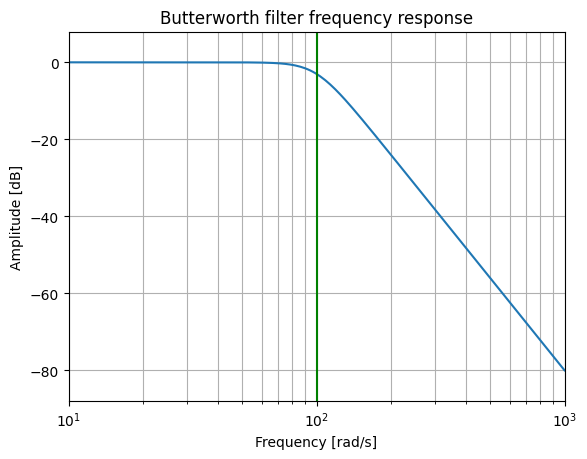

In [28]:
b, a = butter(4, 100, 'low', analog=True)
w, h = freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

### Normalizacja częstotliwości (Częstotliwość Nyquista)

Aby poprawnie wyznaczyć współczynniki filtra cyfrowego (takiego jak filtr Butterwortha), musimy operować na **częstotliwościach znormalizowanych**. Punktem odniesienia dla wszystkich operacji cyfrowych jest tzw. **Częstotliwość Nyquista**.

Jest to maksymalna częstotliwość, jaką można poprawnie zapisać (reprezentować) przy danej częstotliwości próbkowania ($f_s$). Wynosi ona dokładnie połowę częstotliwości próbkowania:

$$f_{Nyquist} = \frac{f_s}{2}$$

#### Dlaczego jest to konieczne?

1.  **Granica fizyczna sygnału cyfrowego:** Żaden system cyfrowy nie jest w stanie rozróżnić częstotliwości wyższych niż $f_{Nyquist}$ od częstotliwości niskich. Próba analizy sygnału o wyższej częstotliwości prowadzi do powstania błędu zwanego **aliasingiem** (nakładaniem widm), gdzie wysokie częstotliwości "udają" niskie, zafałszowując wynik. 

In [29]:
def filter_ekg(signal_data, frequency = 128):
    
    
    fourier_frequency = frequency/2
    low_cut = 0.5 #czestotliwosci wolniejsze od 0.5 to najprawdopodniej ruch klatki piersiowej, powodujacy drift 
    high_cut = 40 # w tym przedziale znajduje sie najwiecej zlamkow, wieksze wartosci to w wiekszosci szum

    normalized_low_cut = low_cut/fourier_frequency
    normalized_high_cut = high_cut/fourier_frequency

    b,a = butter(N = 4, Wn=[normalized_low_cut, normalized_high_cut], btype='band')

    filtered_data = filtfilt(b, a, signal_data, axis = 0)

    filtered_frame = pd.DataFrame(filtered_data, columns=signal_data.columns)

    return filtered_frame

clean_df = filter_ekg(resampled_df)

clean_df.head()


,I,II,III,avR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,8.163490,6.572588,-1.641091,-7.374774,4.955663,2.458511,-3.137310,-6.789411,5.802903,-0.159284,7.984383,5.731224
1,69.004100,71.430828,1.422621,-70.311926,34.300103,35.811302,-441.740423,37.098933,190.850416,166.664741,90.908274,53.376699
2,86.646339,76.652082,-11.219074,-81.698460,49.640171,31.970332,-485.564033,57.068649,227.947710,200.963487,101.568735,70.301061
3,60.893942,43.756026,-17.786145,-52.165471,40.145748,12.061081,-399.535483,65.734884,207.837485,182.761141,93.805469,88.817274
4,30.406218,23.865695,-6.787690,-26.955531,19.438585,7.204125,-419.130894,70.087588,218.601922,195.961667,114.654626,112.901901


### Porównanie wyników filtracji

W celu zmierzenia efektywnosci filtrowania dokonano dwóch wizualizacji.
- nałozenie dwóch sygnałów na siebie i przedstawienie ich na jedym wykresie, rozrózniając kolorami. 
- obliczenie róznicy sygnałów a następnie ich wizualizacja.

W przypadku róznicy im prostsza linia tym róznica pomiędzy filtrowanym sygnałem a nieprzetworzonym jest mniejsza.

##### Aparatura medyczna
Pomiary aparaturą medyczną cechują się wysoką dokładnoscią, więc zwizualizowana mała róznica jest poządanym wynikiem.



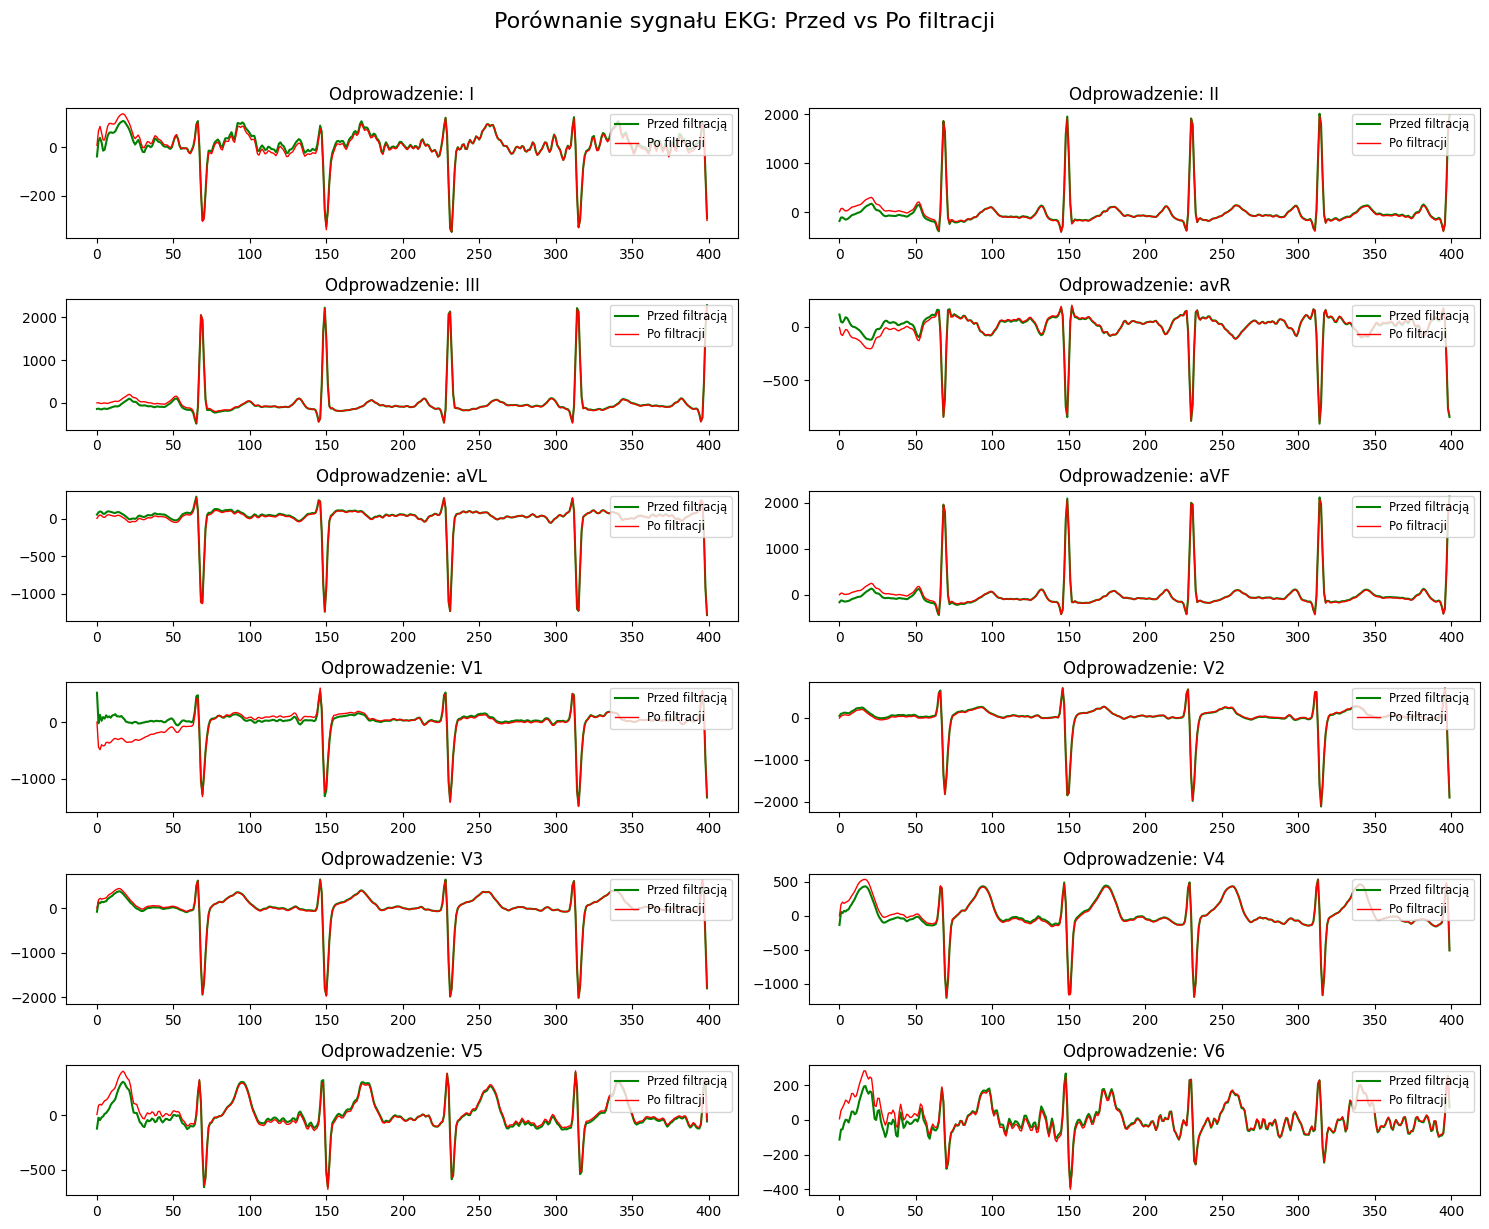

In [30]:
subset_clean = clean_df.iloc[:400]
subset_raw = resampled_df[:400]
import matplotlib.pyplot as plt

columns = subset_clean.columns

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 12))

axes = axes.flatten()



for i, col in enumerate(columns):
    
    subset_raw[col].plot(ax=axes[i], label='Przed filtracją', color='green')
    
    subset_clean[col].plot(ax=axes[i], label='Po filtracji', color='red', linewidth=1)
    
    axes[i].set_title(f"Odprowadzenie: {col}")
    axes[i].legend(loc='upper right', fontsize='small')


plt.suptitle("Porównanie sygnału EKG: Przed vs Po filtracji", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()




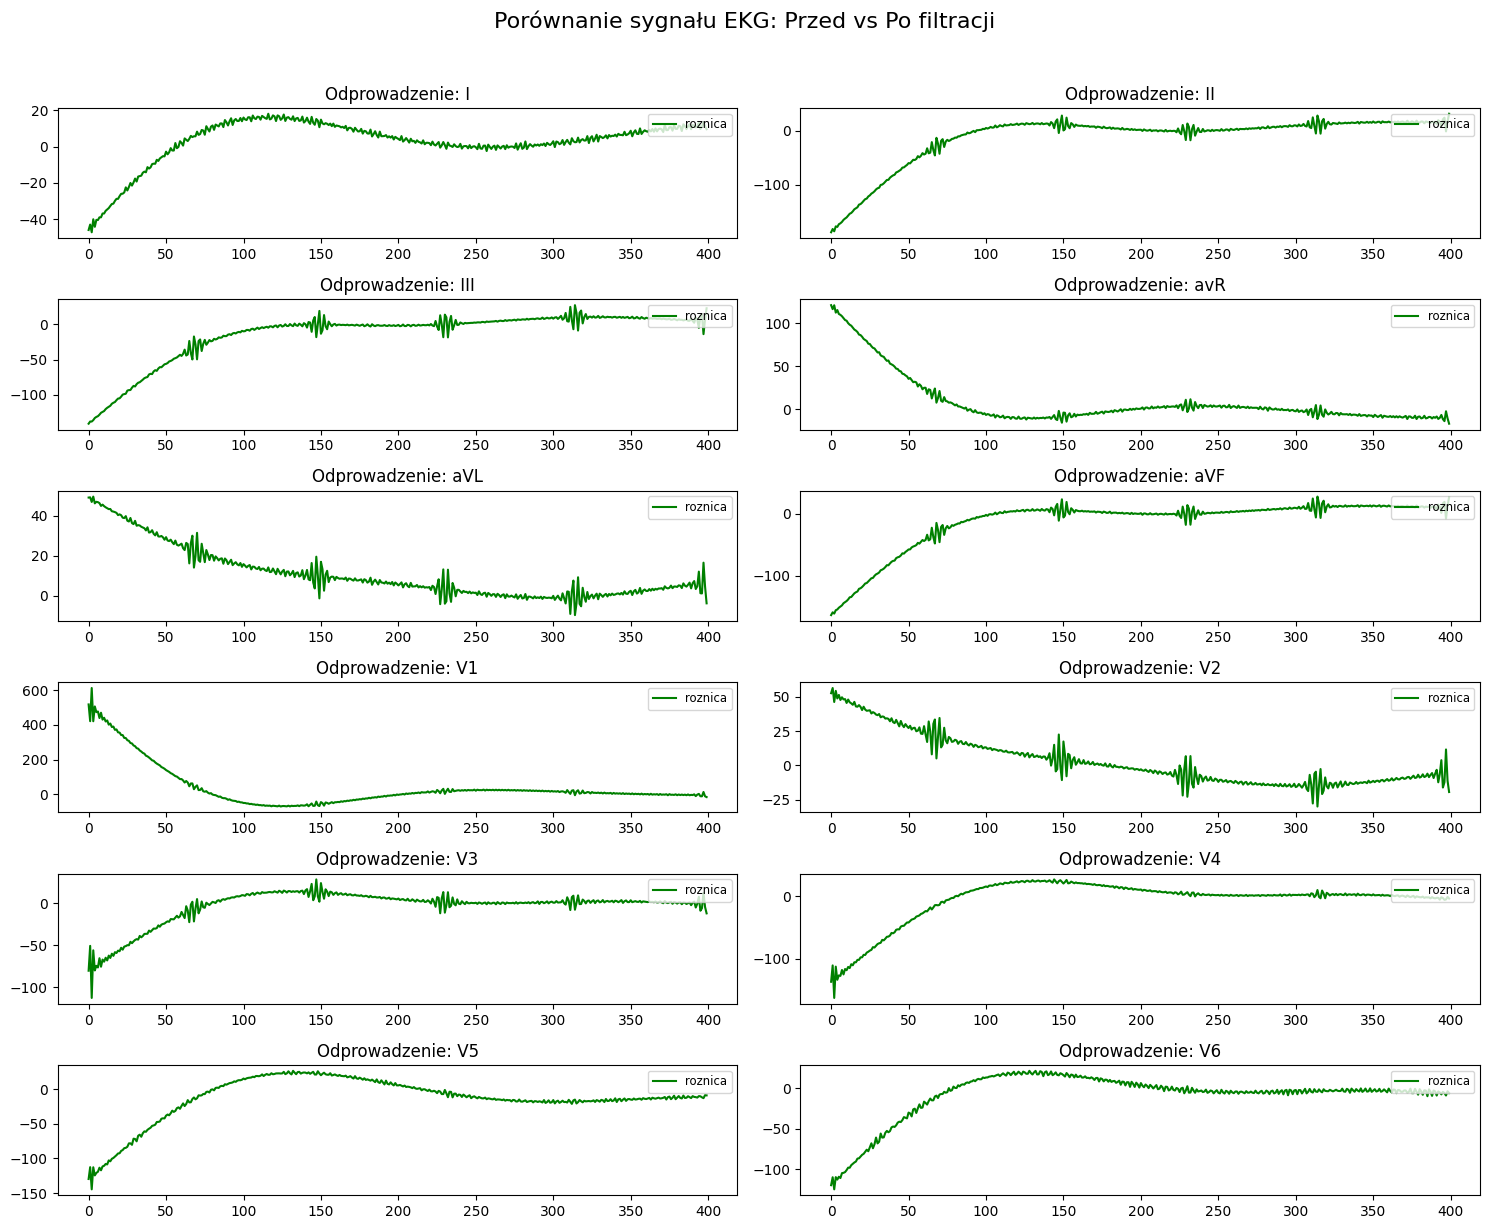

In [ ]:
subset_dif =  resampled_df[:400] - subset_clean[:400]


fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 12))

axes = axes.flatten()

columns = subset_clean.columns

for i, col in enumerate(columns):   
    
    subset_dif[col].plot(ax=axes[i], color='green', label='roznica')
    
    axes[i].set_title(f"Odprowadzenie: {col}")
    axes[i].legend(loc='upper right', fontsize='small')


plt.suptitle("Porównanie sygnału EKG: Przed vs Po filtracji", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


### Podzial sygnalu na okna
5 sekund w pryzpadku wolniejszego bicia serca, moze dac nie wystarczajaca ilosc uderzen do celu analizy.
Przy normalnym biciu serca w 10 sekunach, zmiesci sie do 15 uderzen, ta ilosc bedzie wystarczajaca do analizy.
Przy próbkowaniu 128 Hz daje to: 10×128=1280 próbek w oknie.


In [32]:
def create_windows(df, window_seconds=10, step_seconds=5, fs=128):
    

    window_samples = int(window_seconds * fs) 
    step_samples = int(step_seconds * fs)     
    
    data_array = df.values 
    total_samples = data_array.shape[0]
    num_channels = data_array.shape[1]
    
    windows = []
    

    for start_index in range(0, total_samples - window_samples + 1, step_samples):
        end_index = start_index + window_samples
        
        
        window = data_array[start_index:end_index, :]
        windows.append(window)
        
    X = np.array(windows)
    
    return X

X_data = create_windows(clean_df, window_seconds=10, step_seconds=5, fs=128)

#### Wyznacznanie outlierów

W celu wyznaczenia outlierów, wartosci, za pomocą których zdecydowano się później wykrywać anomalie w oknach, dokonano wizualizacji danych za pomocą histogramu.


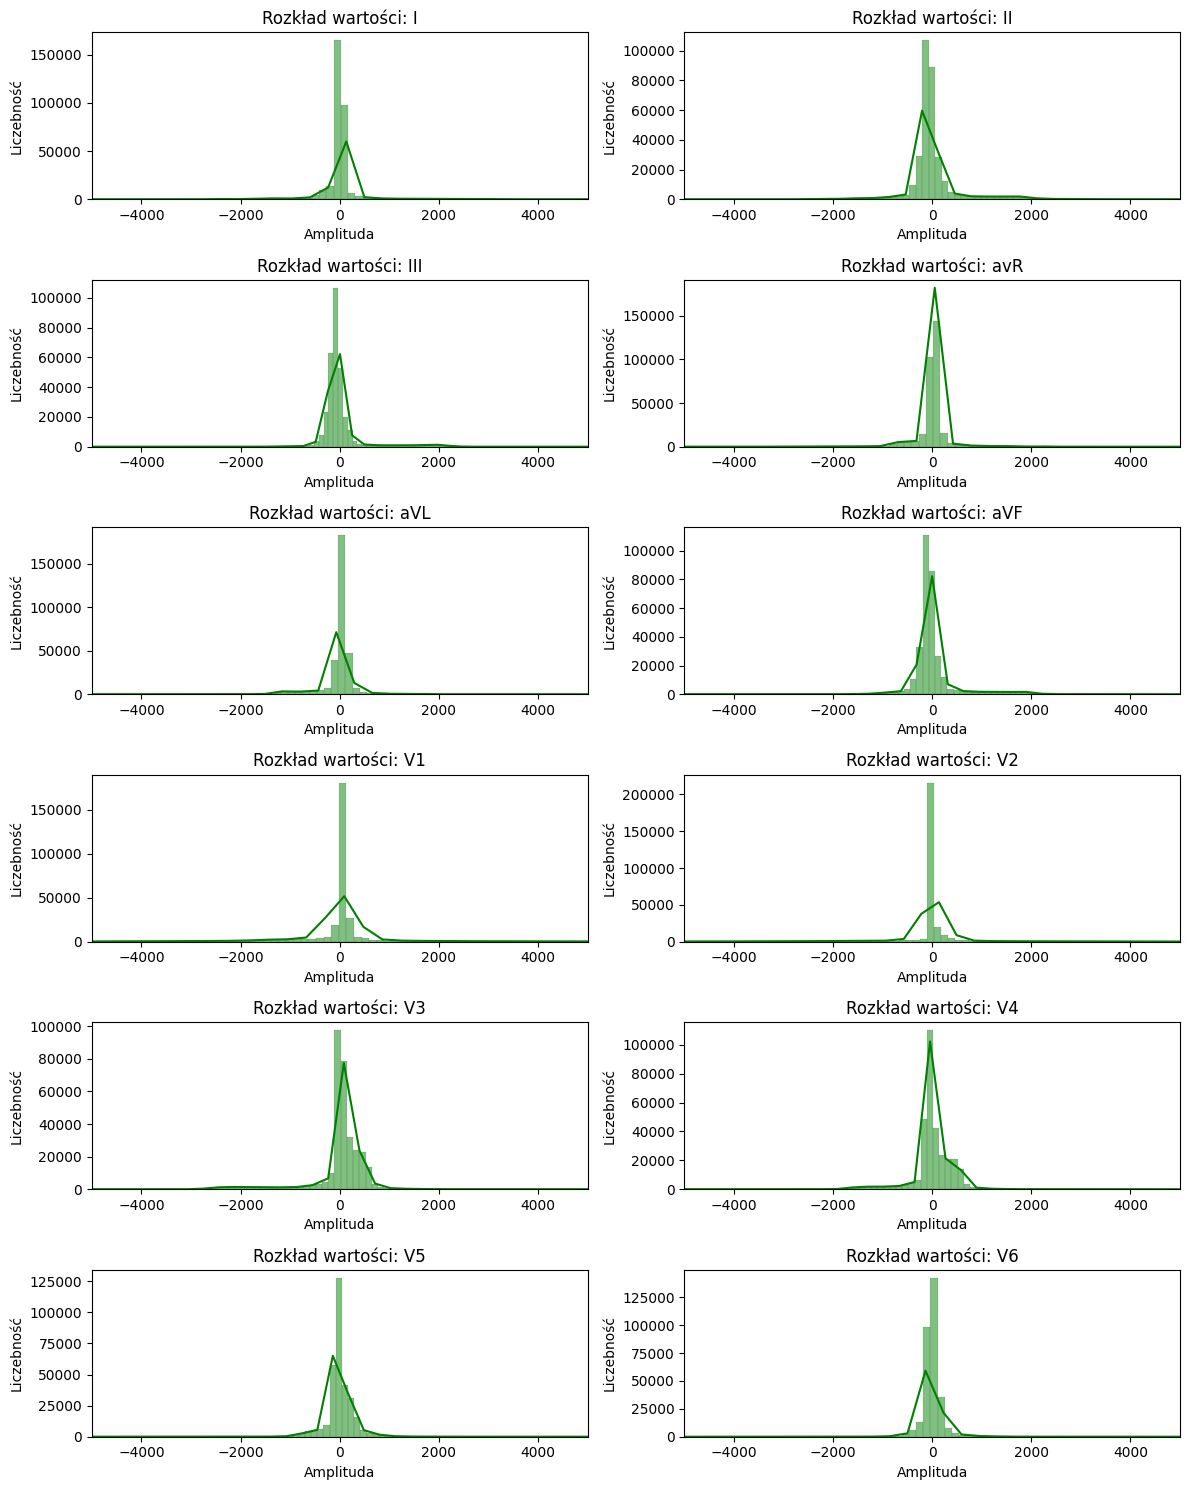

In [33]:
import seaborn as sns

def check_outliers_hist(X_data):

    flattened_data = X_data.reshape(-1, 12) 
    
    
    df_temp = pd.DataFrame(flattened_data, columns=['I','II','III','avR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
    
    figs, axes = plt.subplots(nrows=6, ncols=2, figsize=(12,15))

    axes = axes.flatten()

    columns = df_temp.columns
    for i, col in enumerate(columns):
        sns.histplot(data=df_temp, x=col, ax=axes[i], color='green', kde=True, bins=500)
        

        axes[i].set_xlim(-5000, 5000)
        axes[i].set_title(f"Rozkład wartości: {col}")
        axes[i].set_xlabel("Amplituda")
        axes[i].set_ylabel("Liczebność")
        
    plt.tight_layout()
    plt.show()

X_data = create_windows(clean_df)
check_outliers_hist(X_data)

### Wykrywanie anomalii w oknach
- jesli odchylenie standardowe aplitud w oknie wynosi okolo zera, oznacza najprawdopodniej prosta linie, dlatego pomijamy te wartosci
- jesli maksymalna wartosc w danym oknie wynosi wiecej niz ustalony treshold, w nasyzm przypadku od 3000 do 5000 oznacza wystapienie anomalii,dlatego pomijamy te wartosci.
- jesli róznica pomiaru x i x + 1 jest wieksza niz okreslona wartosc, oznacza za gwałtowną zmianę, wynikającą z zakłócenia, lub zerwania elektrody.

Window jest rozmiaru (1200, 12) oznacza to ze mamy 1200 wartosci w kazdym z kanalow


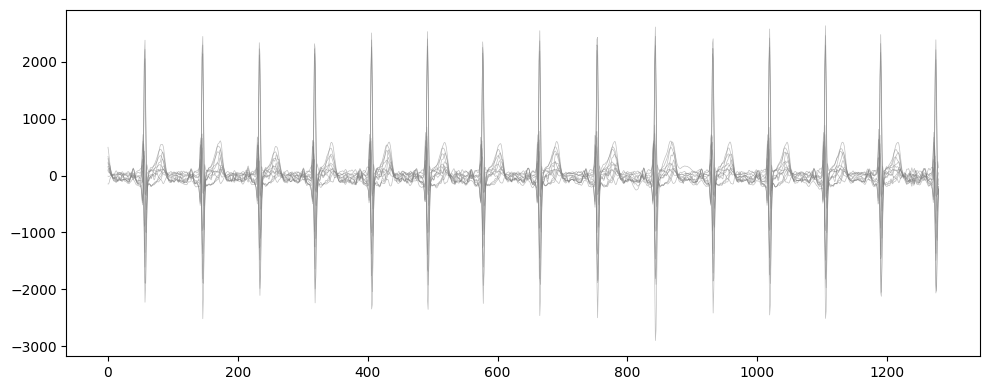

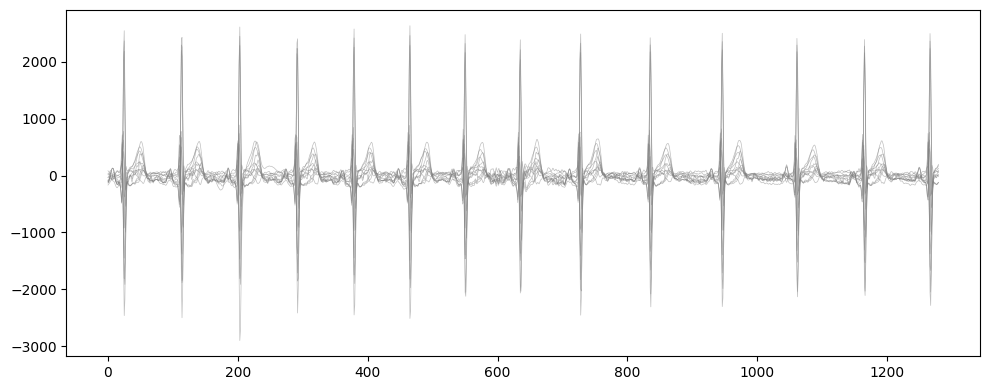

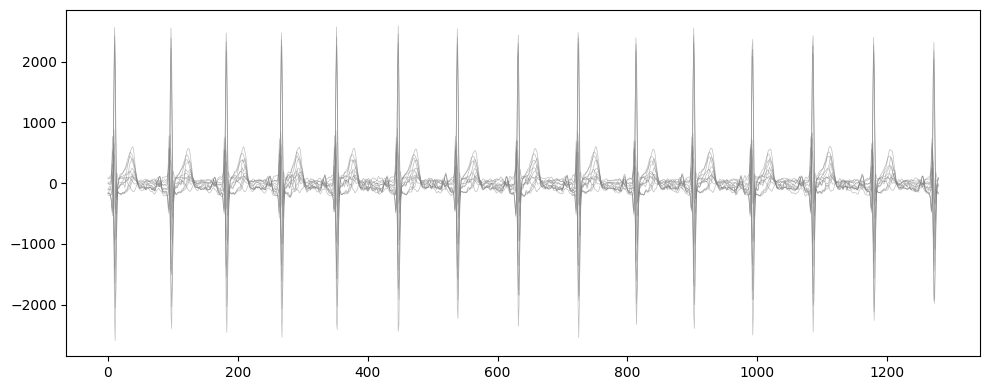

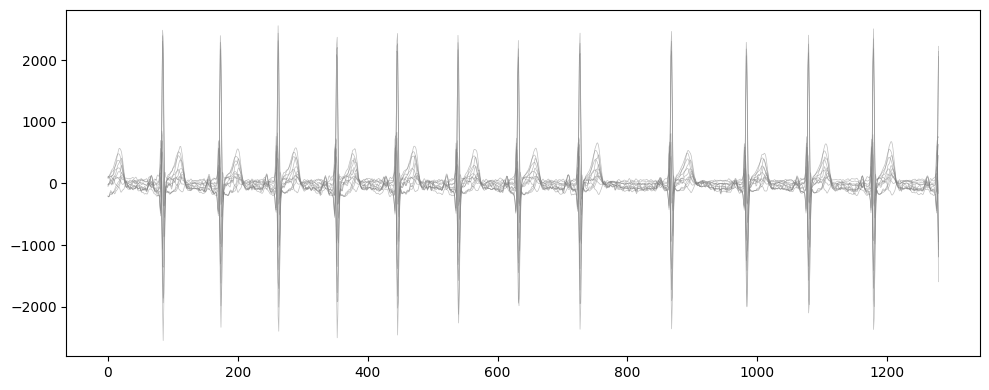

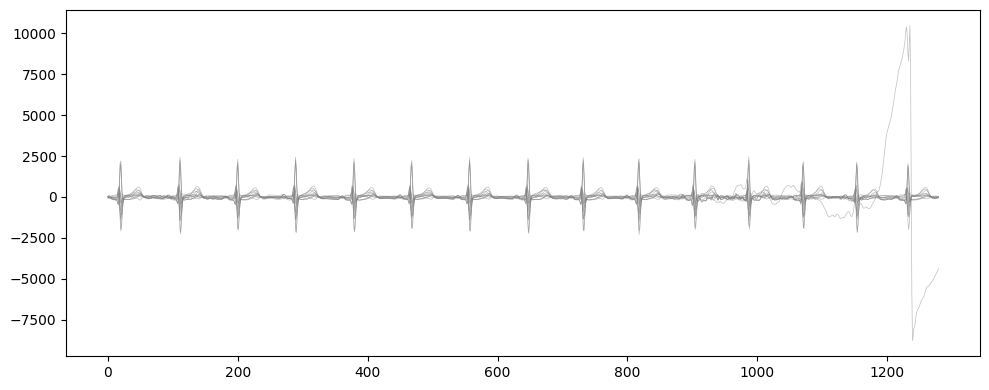

Usunięto 137 okien.
Pozostało 112 dobrych okien.


In [34]:
import numpy as np

def remove_bad_windows(X, threshold_max_amp=1000, threshold_min_std=1.0):

    
    good_indices = []
    visualize_count = 0
    
    
    
    for i in range(len(X)):
        rejection = False
        window = X[i] # Kształt (1280, 12)

        if np.isnan(window).any():
            rejection = True
            
        stds = np.std(window, axis=0)
        if (stds < threshold_min_std).all():
           
            rejection = True
            
        max_val = np.max(np.abs(window))
        if max_val > threshold_max_amp:
            rejection = True
            

        window_flattened = window.reshape(-1, 12) 
        diffs = np.diff(window_flattened, axis=0)
        if (np.abs(diffs) > 1500).any():
            rejection = True

        

        
        if rejection == False:
            good_indices.append(i)
        elif rejection == True and visualize_count < 5:
            plt.figure(figsize=(10, 4))
            plt.plot(window, color='gray', alpha=0.5, linewidth=0.5)
            plt.tight_layout()
            plt.show()
            visualize_count+=1
        

    X_clean = X[good_indices]
    
    print(f"Usunięto {len(X) - len(X_clean)} okien.")
    print(f"Pozostało {len(X_clean)} dobrych okien.")
    
    return X_clean

X_final = remove_bad_windows(X_data, threshold_max_amp=3000, threshold_min_std=0.5)
X_temp=X_final

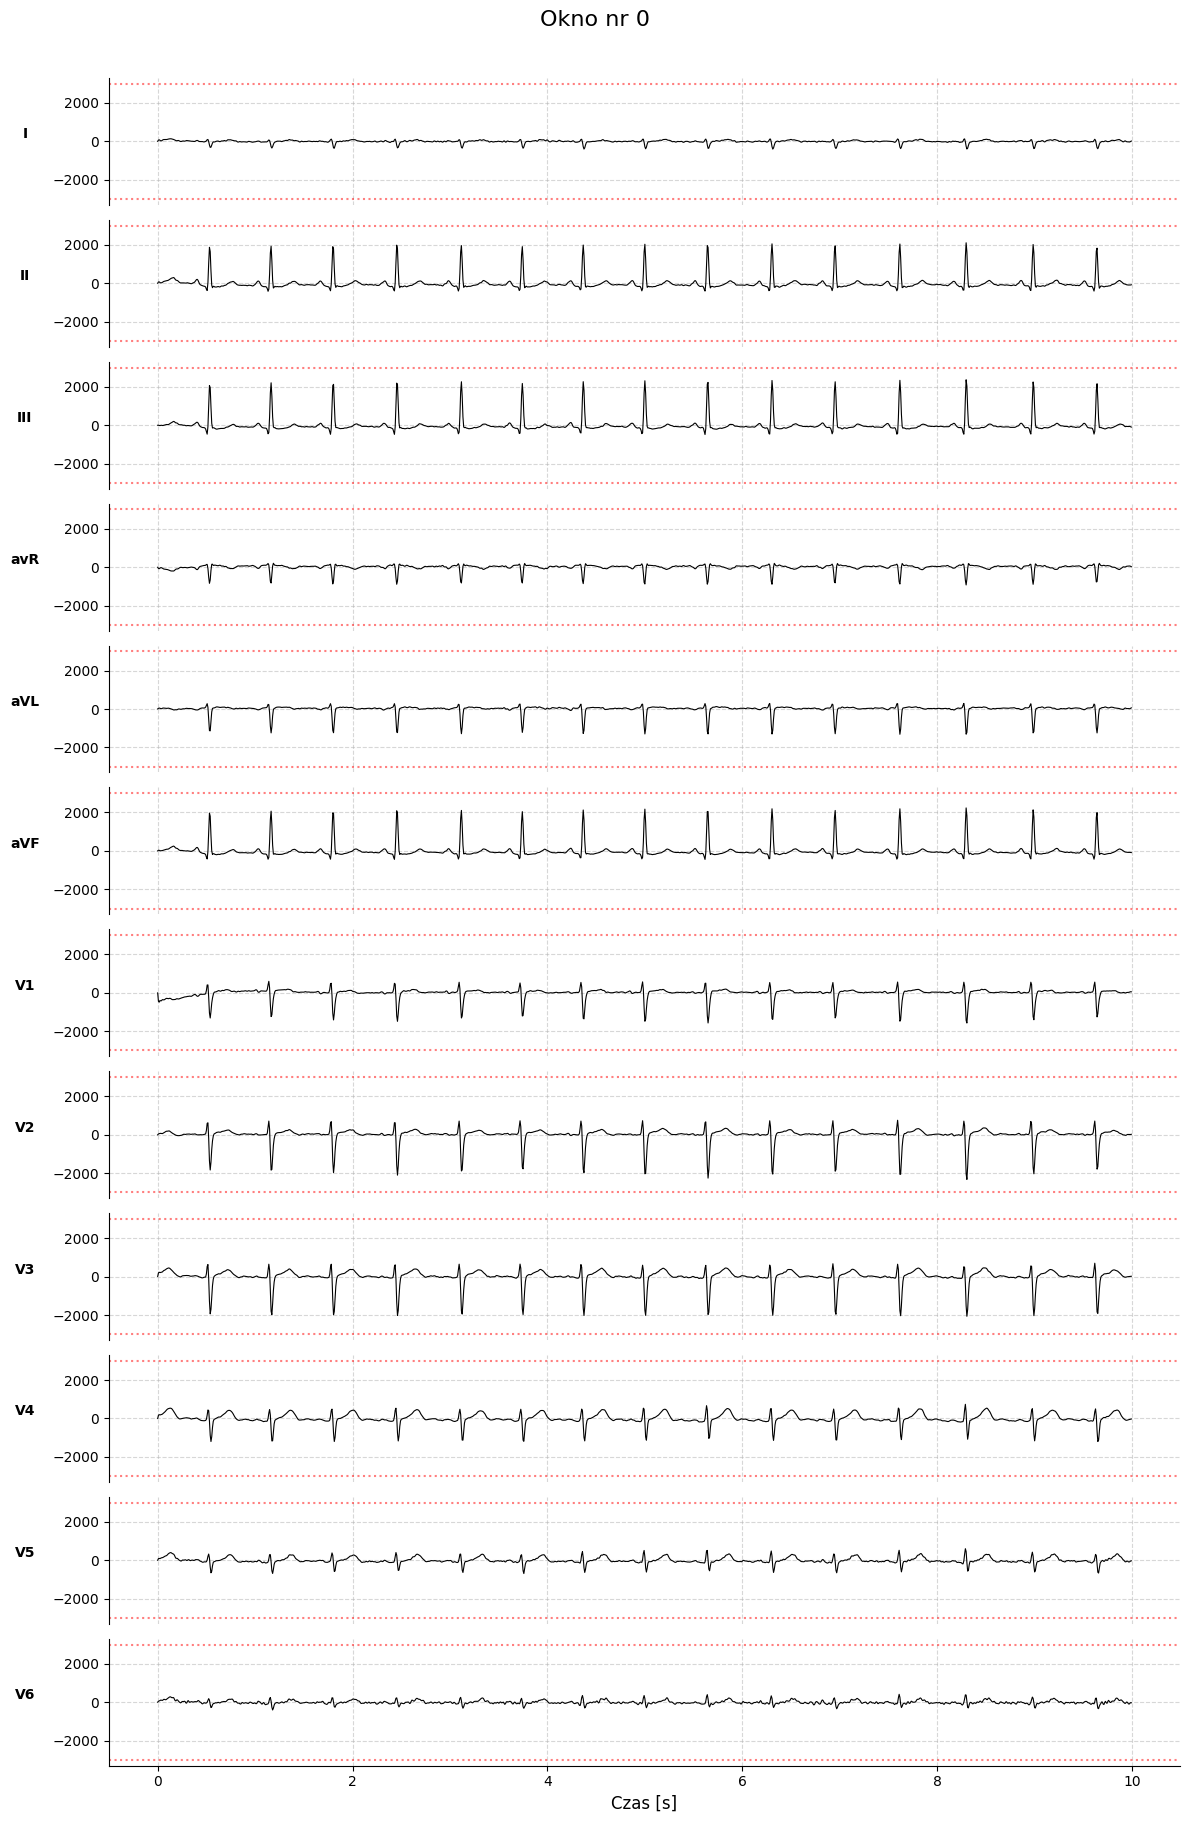

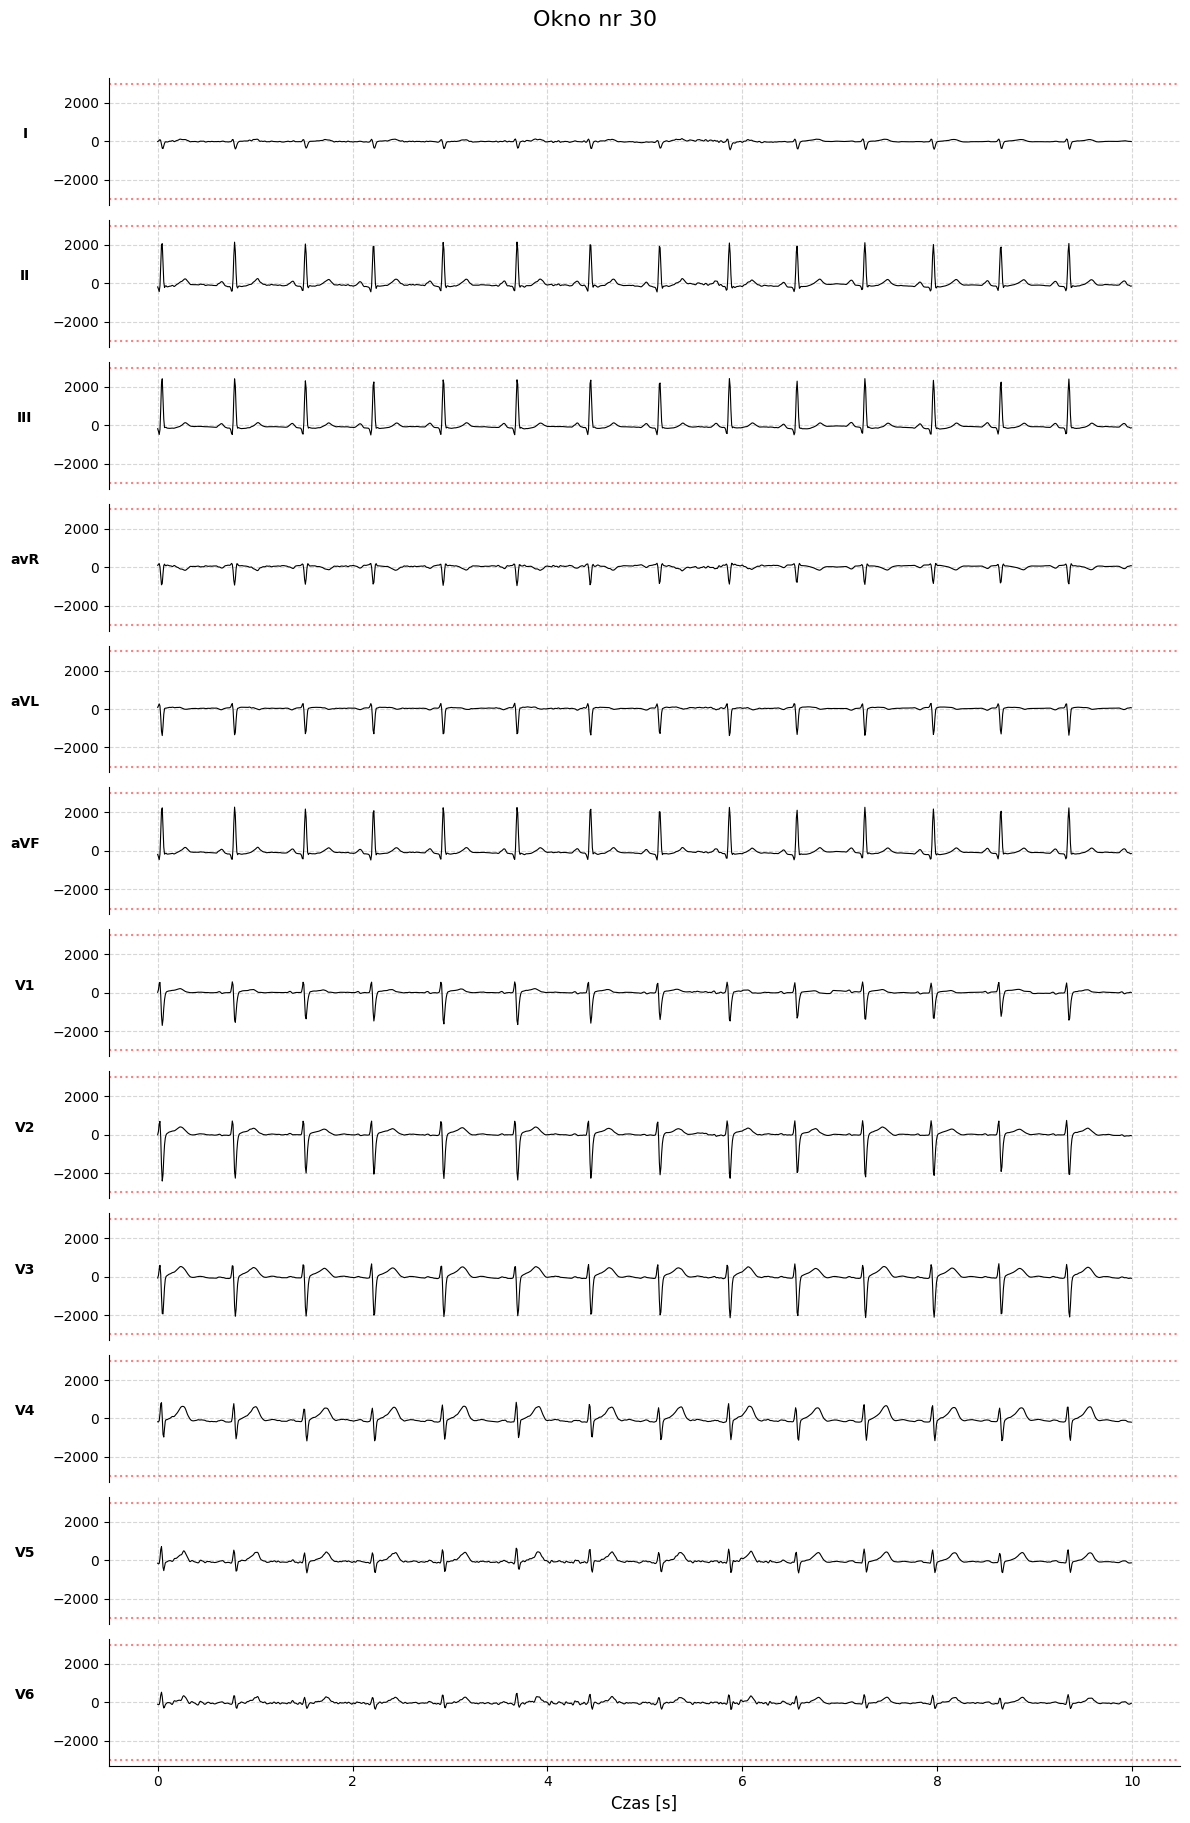

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_window(X_data, window_index, fs=128, threshold=None):
    

    window = X_data[window_index]
    

    time_axis = np.arange(window.shape[0]) / fs
    

    channels = ['I', 'II', 'III', 'avR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    

    fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(12, 18), sharex=True)
    


    for i in range(12):
        ax = axes[i]
        signal = window[:, i]
        
        ax.plot(time_axis, signal, color='black', linewidth=0.8)
        ax.set_ylabel(channels[i], rotation=0, labelpad=20, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.5)
        
        if threshold:
            ax.axhline(y=threshold, color='red', linestyle=':', alpha=0.5)
            ax.axhline(y=-threshold, color='red', linestyle=':', alpha=0.5)
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if i < 11:
            ax.spines['bottom'].set_visible(False)
            ax.tick_params(bottom=False)

    plt.xlabel("Czas [s]", fontsize=12)
    plt.suptitle(f"Okno nr {window_index}", y=1.01, fontsize=16)
    plt.tight_layout()
    plt.show()


visualize_window(X_final, window_index=0, fs=128, threshold=3000)

visualize_window(X_final, window_index=30, fs=128, threshold=3000)

### Garmin (zegarek) — przetwarzanie JSON

Poniższe komórki wykonują analogiczne operacje dla danych z zegarka (plik JSON):
- ładowanie surowych próbek z JSON
- wykrycie częstotliwości próbkowania (jeśli dostępne)
- resampling do docelowej częstotliwości (domyślnie 128 Hz)
- filtracja pasmowo-przepustowa (używa `filter_ekg` jeśli jest zdefiniowana)
- dzielenie na okna, wizualizacje i zapis przetworzonych danych

In [36]:
import json
#file_path = '/Users/janmichorek/Documents/ProgrammingProjects/HeartAnalisisProject/Projekt-EKG1/Projekt-EKG/data/N36/GARMIN-RECORDINGS/2025-11-14T09-44-17.0_23004d11-0864-4ce7-8a65-fc5b742e4e28.json' 
file_path = 'data/N36/GARMIN-RECORDINGS/2025-11-14T09-44-17.0_23004d11-0864-4ce7-8a65-fc5b742e4e28.json'
try:
    with open(file_path, 'r') as f:
        json_data = json.load(f)
        raw_samples = json_data['reading']['samples']
        df_watch = pd.DataFrame(raw_samples, columns=["I"])   
    
    print(f"Wczytano {len(df)} próbek.")

except FileNotFoundError:
    print("Nie znaleziono pliku")



Wczytano 625210 próbek.


In [37]:
#filter watch_df

clean_df_watch = filter_ekg(df_watch)

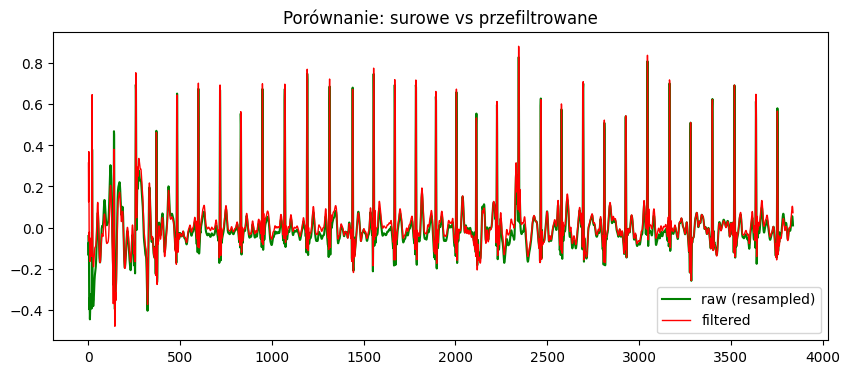

In [38]:
plt.figure(figsize=(10,4))
plt.plot(clean_df_watch, label='raw (resampled)', color='green')
plt.plot(df_watch, label='filtered', color='red', linewidth=1)
plt.title('Porównanie: surowe vs przefiltrowane')
plt.legend()
plt.show()

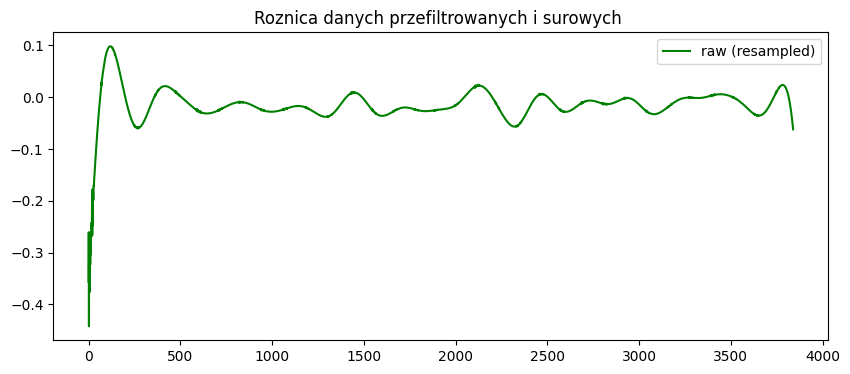

In [39]:
diff_df = clean_df_watch - df_watch

plt.figure(figsize=(10,4))
plt.plot(diff_df, label='raw (resampled)', color='green')
plt.title('Roznica danych przefiltrowanych i surowych ')
plt.legend()
plt.show()

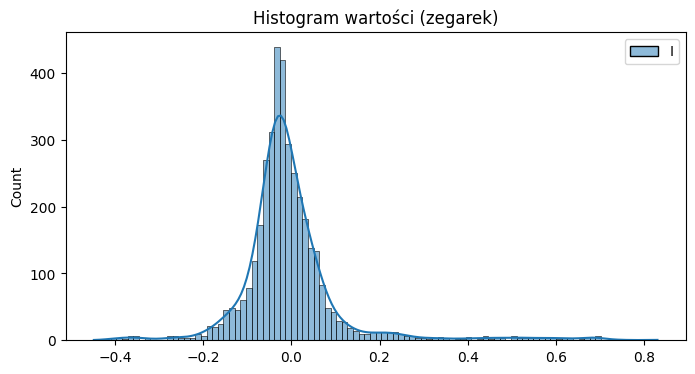

In [40]:
import seaborn as sns
plt.figure(figsize=(8,4))
sns.histplot(clean_df_watch, bins=100, kde=True, color='blue')
plt.title('Histogram wartości (zegarek)')
plt.show()

In [41]:
def create_windows(df, window_seconds=10, step_seconds=5, fs=128):
    

    window_samples = int(window_seconds * fs) 
    step_samples = int(step_seconds * fs)     
    
    data_array = df.values 
    total_samples = data_array.shape[0]
    num_channels = data_array.shape[1]
    
    windows = []
    

    for start_index in range(0, total_samples - window_samples + 1, step_samples):
        end_index = start_index + window_samples
        
        
        window = data_array[start_index:end_index, :]
        windows.append(window)
        
    X = np.array(windows)
    print(len(windows))
    
    return X

X_data = create_windows(clean_df_watch, window_seconds=10, step_seconds=5, fs=128)

5


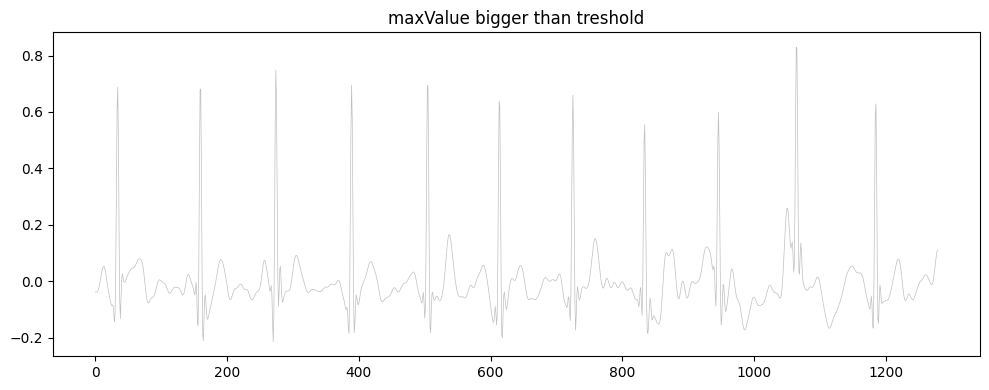

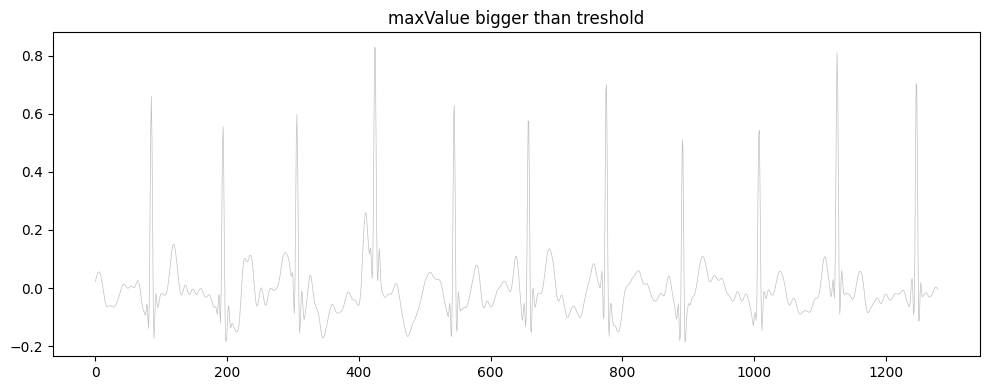

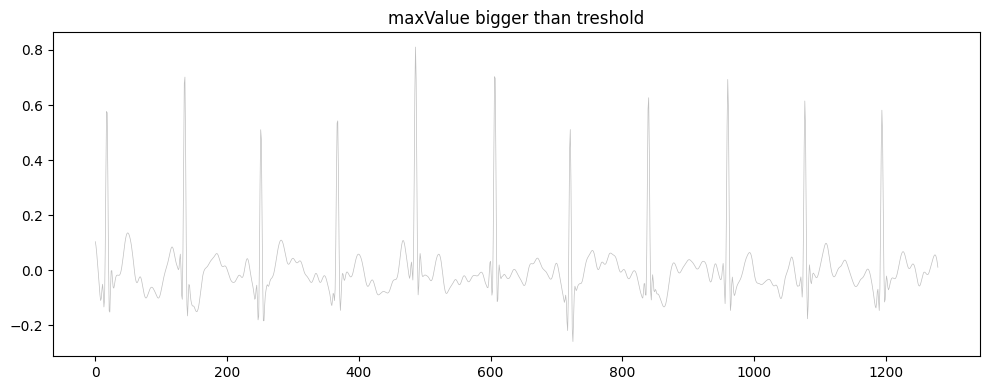

Usunięto 3 okien.
Pozostało 2 dobrych okien.


In [42]:
import numpy as np

def remove_bad_windows(X, threshold_max_amp=1, threshold_min_std=0.05):

    
    good_indices = []
    visualize_count = 0
    rejection_reason = None
    
    
    for i in range(len(X)):
        rejection = False
        window = X[i] # Kształt (1280, 1)

        if np.isnan(window).any():
            rejection = True
            rejection_reason = "NanValues"
            
        stds = np.std(window, axis=0)
        if (stds < threshold_min_std).all():
            rejection = True
            rejection_reason = f"too flat (std={stds[0]:.3f})"

            
        max_val = np.max(np.abs(window))
        if max_val > threshold_max_amp:
            rejection = True
            rejection_reason = "maxValue bigger than treshold"
            

        
        diffs = np.diff(window, axis=0)
        if (np.abs(diffs) > 1).any():
            rejection = True
            rejection_reason = "too rapid change"

        

        
        if rejection == False:
            good_indices.append(i)
        elif rejection == True and visualize_count < 5:
            plt.figure(figsize=(10, 4))
            plt.title(rejection_reason)
            plt.plot(window, color='gray', alpha=0.5, linewidth=0.5)
            plt.tight_layout()
            plt.show()
            visualize_count+=1
        

    X_clean = X[good_indices]
    
    print(f"Usunięto {len(X) - len(X_clean)} okien.")
    print(f"Pozostało {len(X_clean)} dobrych okien.")
    
    return X_clean

X_final = remove_bad_windows(X_data, threshold_max_amp=0.8, threshold_min_std=0.1)

Text(0.5, 1.0, 'Wizualizacja okna nr 0 (Zegarek)')

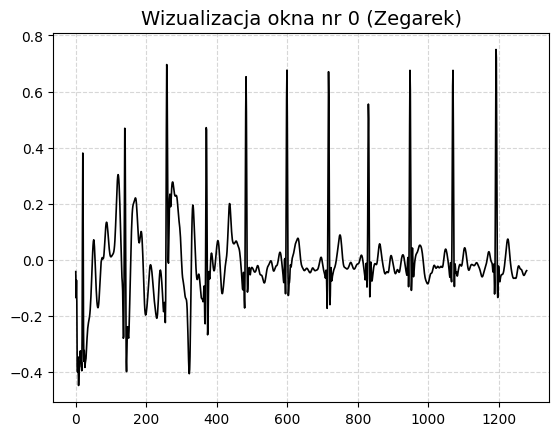

In [43]:
window = X_data[0]
signal = window.flatten()
plt.plot(signal, color='black', linewidth=1.2, label='Sygnał EKG')
plt.grid(True, linestyle='--', alpha=0.5)
plt.title(f"Wizualizacja okna nr 0 (Zegarek)", fontsize=14)





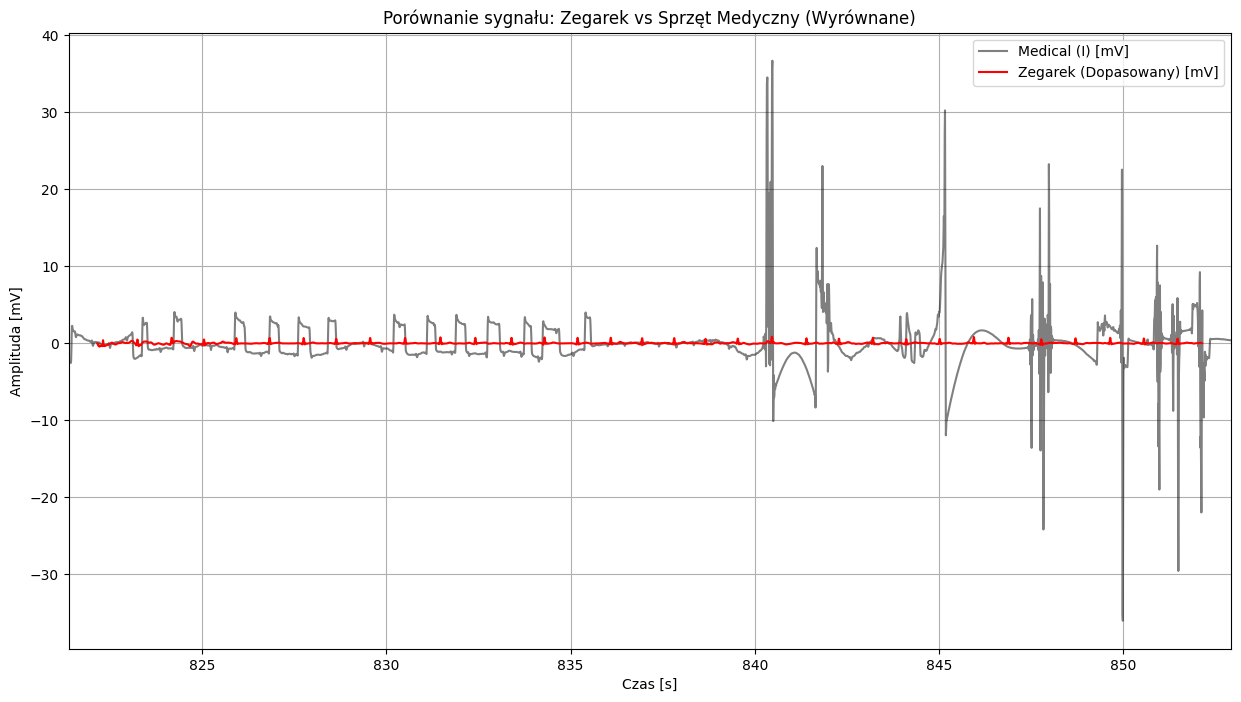

In [44]:
from scipy.signal import correlate

def align_watch_vs_medical(medical_data, watch_data, csv_fs, watch_fs, lead_csv='I'):
    
    sig_long = medical_data[lead_csv].values.flatten()
    
    sig_short = watch_data["I"].values.flatten()

    #zamiana jednostek
    sig_long = sig_long / 1000

    long_centered = sig_long - np.mean(sig_long)
    short_centered = sig_short - np.mean(sig_short)
    
    corr = correlate(long_centered, short_centered, mode='valid')
    best_idx = np.argmax(corr)

    plt.figure(figsize=(15, 8))
    
    t_long = np.arange(len(sig_long)) / 128
    t_short = (np.arange(len(sig_short)) + best_idx) / 128
    
    plt.plot(t_long, sig_long, color='black', alpha=0.5, label=f'Medical ({lead_csv}) [mV]')
    plt.plot(t_short, sig_short, color='red', linewidth=1.5, label='Zegarek (Dopasowany) [mV]')
    
    plt.xlim((best_idx - 100)/128, (best_idx + len(sig_short) + 100)/128)
    
    plt.title("Porównanie sygnału: Zegarek vs Sprzęt Medyczny (Wyrównane)")
    plt.xlabel("Czas [s]")
    plt.ylabel("Amplituda [mV]")
    plt.legend()
    plt.grid(True)
    plt.show()



align_watch_vs_medical(clean_df, clean_df_watch, csv_fs=500, watch_fs=128, lead_csv='I')

In [53]:
#pobranie by użyć w z3
import pickle



# 1. BIERZEMY EKG Z X_temp
if 'X_temp' in locals() and len(X_temp) > 0:
    # Sklejamy okna
    ecg_all_leads = np.concatenate(X_temp)
    # Wybieramy Odprowadzenie II (indeks 1)
    if ecg_all_leads.ndim > 1 and ecg_all_leads.shape[1] > 1:
        ecg_ready = ecg_all_leads[:, 1]
    else:
        ecg_ready = ecg_all_leads.flatten() # Jeśli to już była jedna kolumna
    #print(f"✅ EKG (z X_temp): {len(ecg_ready)} próbek (ok. {len(X_temp)} okien).")
else:
    print(" BŁĄD: Brak zmiennej X_temp! Uruchom komórki wyżej w z2.")
    ecg_ready = []

# 2. BIERZEMY ZEGAREK Z X_final
# X_final to Twoja zmienna z oknami Zegarka (kształt: N, 1280, 1)
# UWAGA: Upewnij się, że ostatnia rzecz, jaką robiłeś w z2, to przetwarzanie zegarka!
if 'X_final' in locals() and len(X_final) > 0:
    watch_ready = np.concatenate(X_final).flatten()
    #print(f"✅ Zegarek (z X_final): {len(watch_ready)} próbek (ok. {len(X_final)} okien).")
else:
    print(" OSTRZEŻENIE: Brak zmiennej X_final lub jest pusta.")
    watch_ready = []

# 3. ZAPIS DO PLIKU
data_package = {
    "ECG_Clean": ecg_ready,
    "Watch_Clean": watch_ready,
    "fs": 128
}

with open("clean_data_no_anomalies.pkl", "wb") as f:
    pickle.dump(data_package, f)

print(f"\n✅ Zapisano plik 'clean_data_no_anomalies.pkl'.")



✅ Zapisano plik 'clean_data_no_anomalies.pkl'.
